## Modeling

### Import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.style.use('seaborn-talk')

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

springfield = pd.read_csv('data/springfield.csv', index_col='date')
springfield_diff_2 = pd.read_csv('data/springfield_diff_2.csv', index_col='date')

### Train/Test Split

In [2]:
springfield

,65807,65802,65804,65810,65806,65809
date,,,,,,
1996-04-01,80800.0,64800.0,83200.0,117900.0,38800.0,158200.0
1996-05-01,80800.0,64100.0,83200.0,116800.0,38500.0,158000.0
1996-06-01,80900.0,63500.0,83300.0,115900.0,38200.0,158000.0
1996-07-01,81100.0,63000.0,83500.0,115200.0,38000.0,158100.0
1996-08-01,81400.0,62600.0,83700.0,114800.0,37600.0,158300.0
...,...,...,...,...,...,...
2017-12-01,119900.0,94800.0,141800.0,192000.0,61000.0,257400.0
2018-01-01,120500.0,95400.0,141800.0,192900.0,61600.0,257500.0
2018-02-01,121400.0,95900.0,142800.0,195000.0,61700.0,260400.0


In [3]:
test_cutoff = 220


# dataset that is already .diff() twice
sf_diff_train = springfield_diff_2[0 : test_cutoff]
sf_diff_test = springfield_diff_2[test_cutoff :]

# original working dataset
sf_train = springfield[0 : test_cutoff]
sf_test = springfield[test_cutoff :]

In [4]:
print(round(len(sf_train)/12, 2))
print(round(len(sf_test)/12, 2))

18.33
3.75


## ARMA

### ACF and PACF Charts

In [57]:
def acf_pacf_charts(df):
    n = len(df.columns)
    fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(12, 25))
    fig.suptitle('Autocorrelations by Zip Code', y=1.03, fontsize=30)

    for i, col in enumerate(springfield_diff_2.columns):
        plot_acf(df[col], ax=axs[i][0], title='ACF: '+col)
        plot_pacf(df[col], ax=axs[i][1], title='PACF: '+col)

    plt.tight_layout()
    fig.subplots_adjust(hspace=.41, wspace=.17)
    plt.show()
    

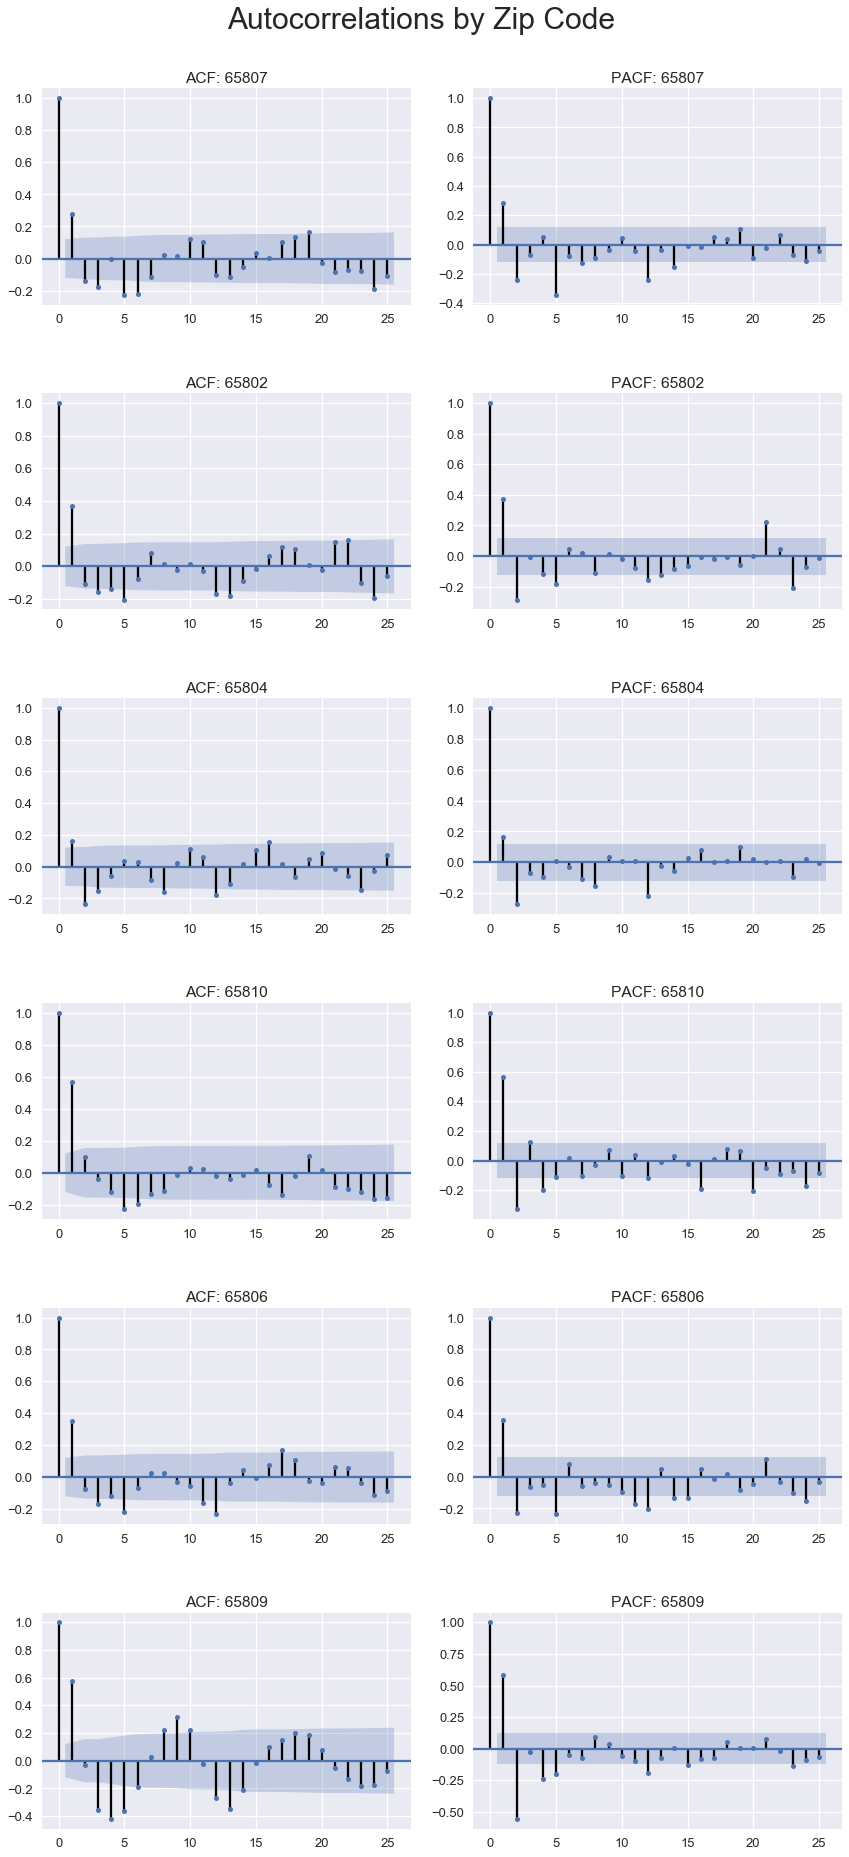

In [58]:
acf_pacf_charts(springfield_diff_2)

### Model

> order is (p,q) p is determined by the AR (pacf), q is determined by the MA (acf)

                              ARMA Model Results                              
Dep. Variable:                  65807   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1463.280
Method:                       css-mle   S.D. of innovations            187.156
Date:                Fri, 29 Jan 2021   AIC                           2932.560
Time:                        02:02:08   BIC                           2942.741
Sample:                    06-01-1996   HQIC                          2936.671
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4473     20.904      0.021      0.983     -40.524      41.418
ar.L1.65807     0.3982      0.062      6.456      0.000       0.277       0.519
                                    Roots       

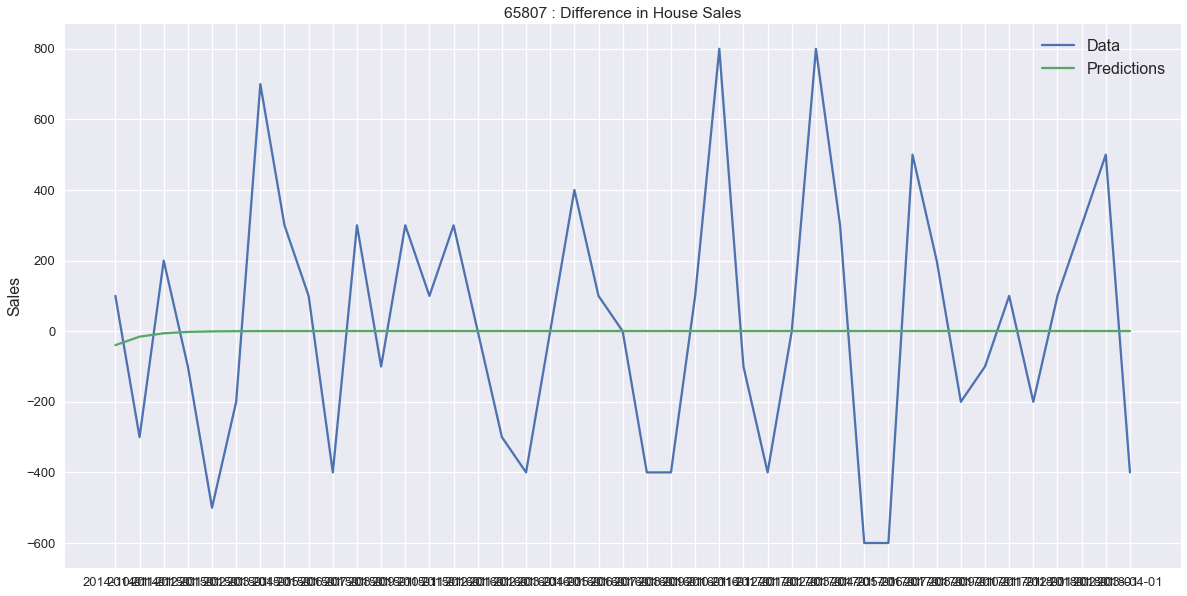

RMSE:  354

 
 

                              ARMA Model Results                              
Dep. Variable:                  65802   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1458.270
Method:                       css-mle   S.D. of innovations            182.925
Date:                Fri, 29 Jan 2021   AIC                           2922.540
Time:                        02:02:08   BIC                           2932.721
Sample:                    06-01-1996   HQIC                          2926.651
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0034     21.839      0.046      0.963     -41.801      43.808
ar.L1.65802     0.4373      0.061      7.219      0.000       0.319       0.556
                               

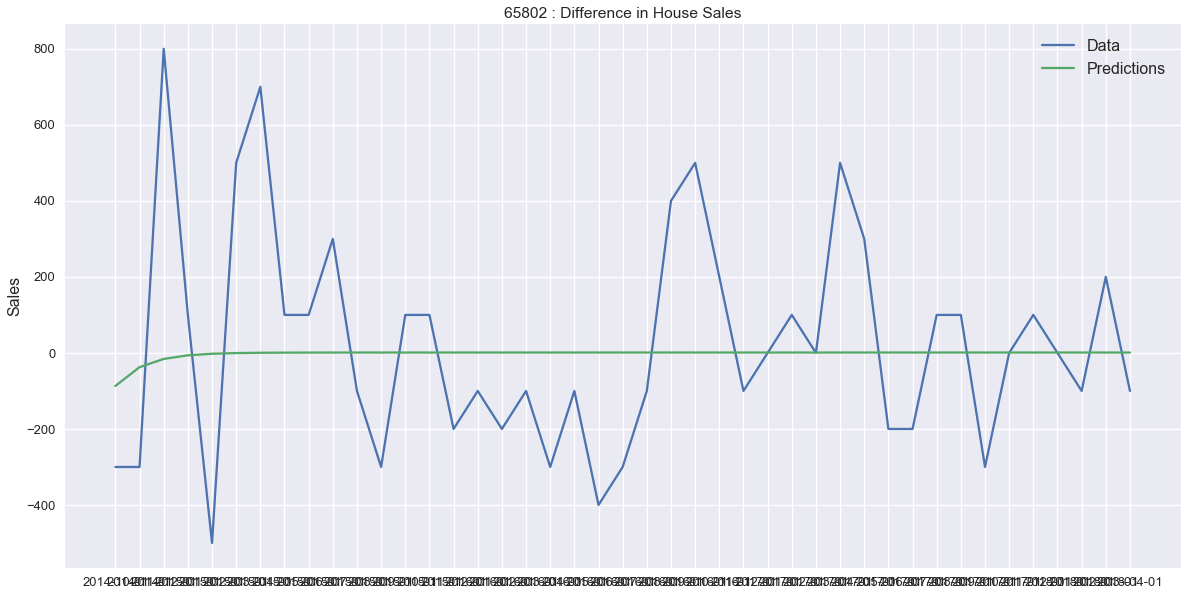

RMSE:  287

 
 

                              ARMA Model Results                              
Dep. Variable:                  65804   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1457.950
Method:                       css-mle   S.D. of innovations            182.744
Date:                Fri, 29 Jan 2021   AIC                           2921.900
Time:                        02:02:09   BIC                           2932.081
Sample:                    06-01-1996   HQIC                          2926.012
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.0792     13.582     -0.079      0.937     -27.699      25.540
ar.L1.65804     0.0931      0.068      1.366      0.172      -0.041       0.227
                               

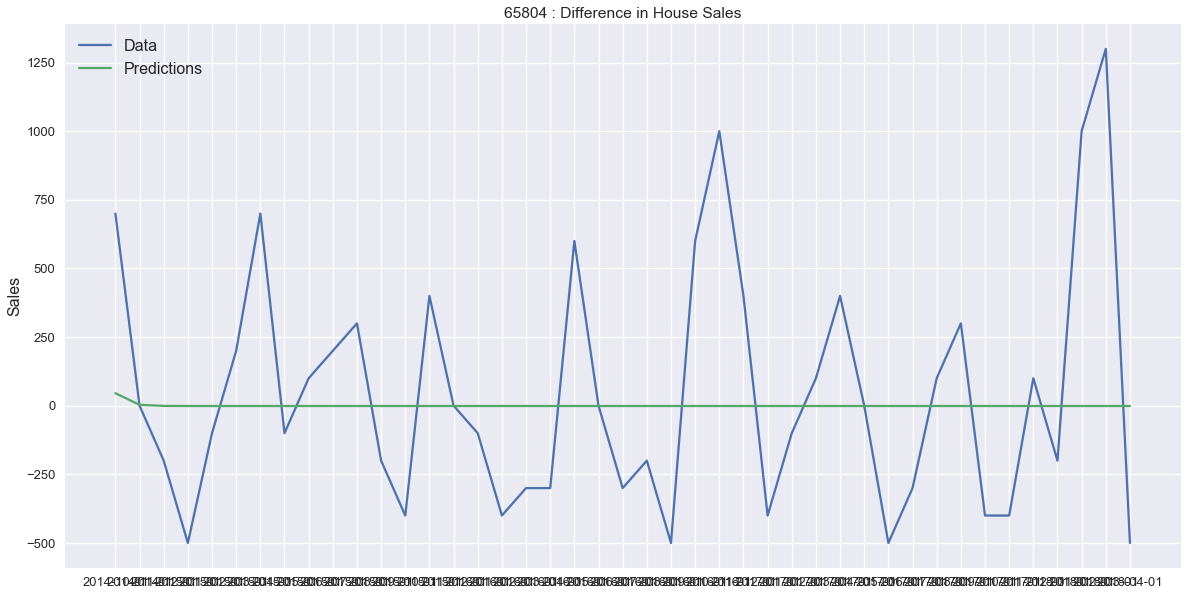

RMSE:  444

 
 

                              ARMA Model Results                              
Dep. Variable:                  65810   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1568.904
Method:                       css-mle   S.D. of innovations            302.264
Date:                Fri, 29 Jan 2021   AIC                           3143.809
Time:                        02:02:09   BIC                           3153.990
Sample:                    06-01-1996   HQIC                          3147.920
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.8828     54.543      0.035      0.972    -105.019     108.784
ar.L1.65810     0.6292      0.052     11.985      0.000       0.526       0.732
                               

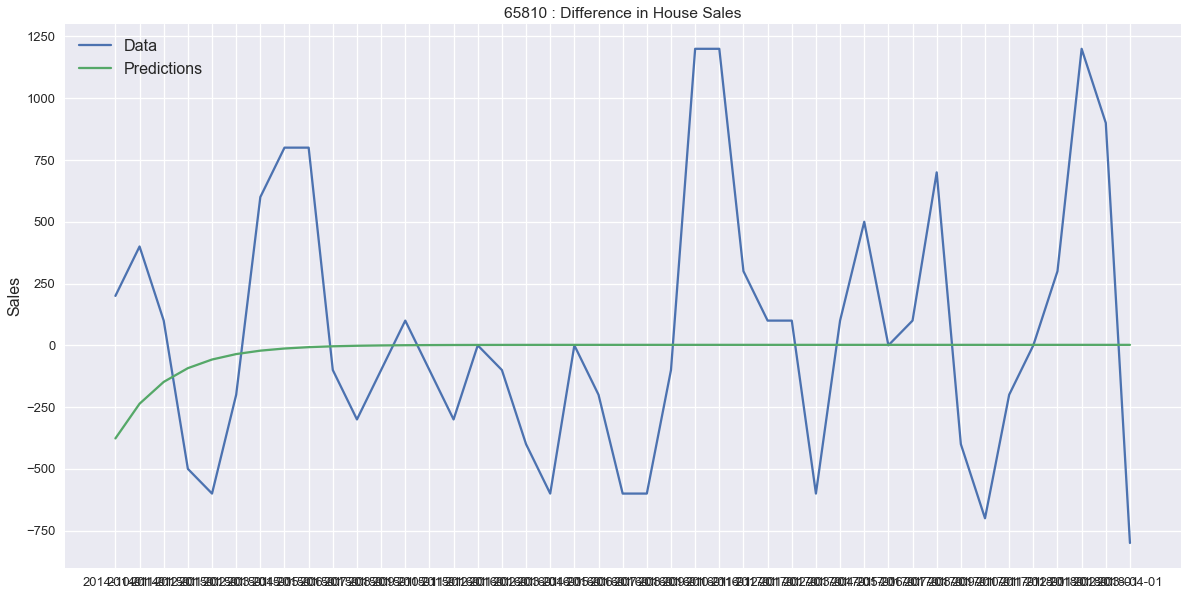

RMSE:  534

 
 

                              ARMA Model Results                              
Dep. Variable:                  65806   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1481.049
Method:                       css-mle   S.D. of innovations            202.903
Date:                Fri, 29 Jan 2021   AIC                           2968.098
Time:                        02:02:09   BIC                           2978.279
Sample:                    06-01-1996   HQIC                          2972.209
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.3249     22.387     -0.059      0.953     -45.202      42.552
ar.L1.65806     0.3907      0.062      6.288      0.000       0.269       0.512
                               

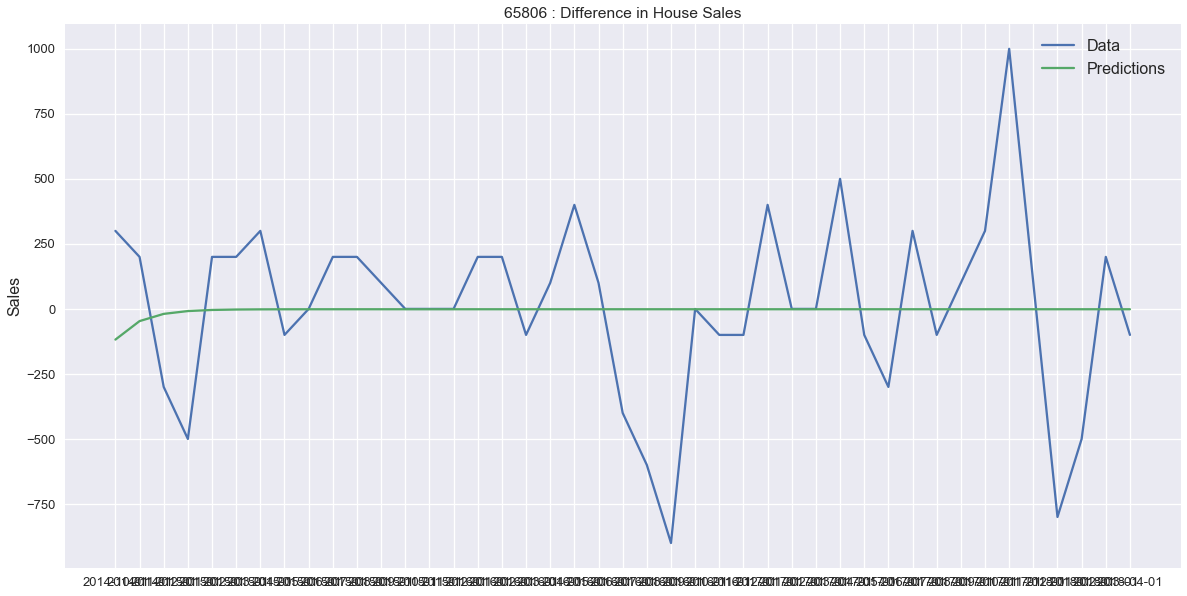

RMSE:  345

 
 

                              ARMA Model Results                              
Dep. Variable:                  65809   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1744.213
Method:                       css-mle   S.D. of innovations            670.468
Date:                Fri, 29 Jan 2021   AIC                           3494.427
Time:                        02:02:10   BIC                           3504.608
Sample:                    06-01-1996   HQIC                          3498.538
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.4742    133.856      0.063      0.950    -253.879     270.827
ar.L1.65809     0.6653      0.050     13.315      0.000       0.567       0.763
                               

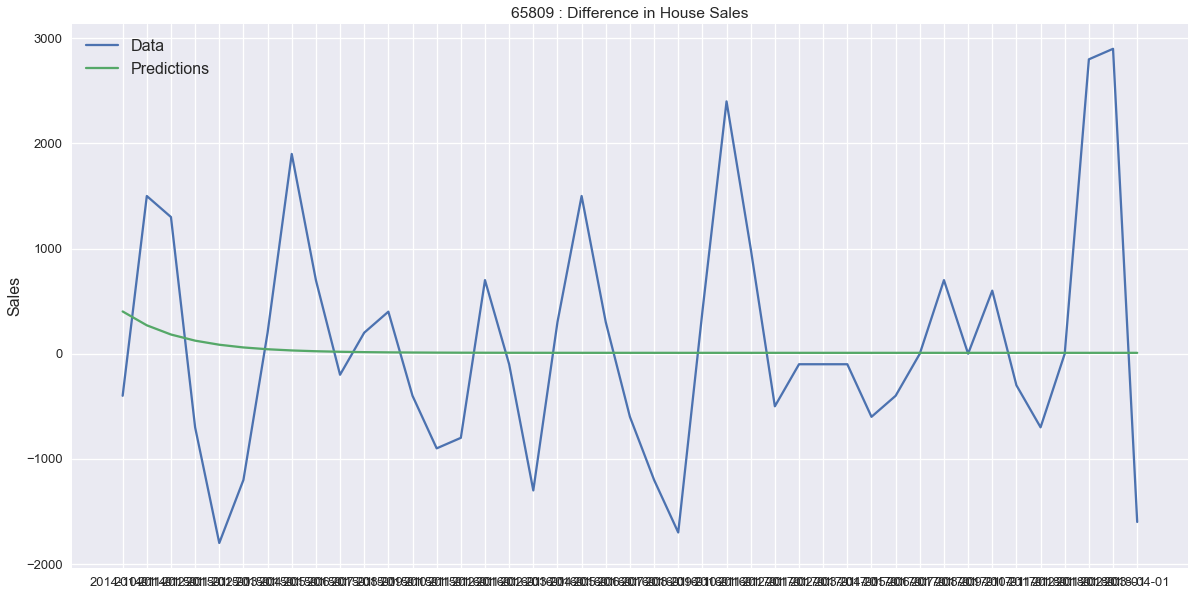

RMSE:  1103

 
 



In [8]:
for col in sf_diff_train:
    
    #creating the ARMA Model
    arma = ARMA(sf_diff_train[col], order=(1,0), freq='MS').fit()
    print(arma.summary())
    
    arma_forecast = arma.forecast(steps=len(sf_diff_test[col]))[0]
    RMSE = np.sqrt(mean_squared_error(sf_diff_test[col], arma_forecast))
    
    # plotting forecast vs actual
    plt.figure(figsize=(20,10))

    plt.plot(sf_diff_test[col])
    plt.plot(arma_forecast)

    plt.legend(('Data', 'Predictions'), fontsize=16)
    plt.title(col + ' : Difference in House Sales')
    plt.ylabel('Sales', fontsize=16);
    
    plt.show()

    print('RMSE: ', round(RMSE))
    print('\n \n \n')

## ARIMA

### ACF and PACF Charts

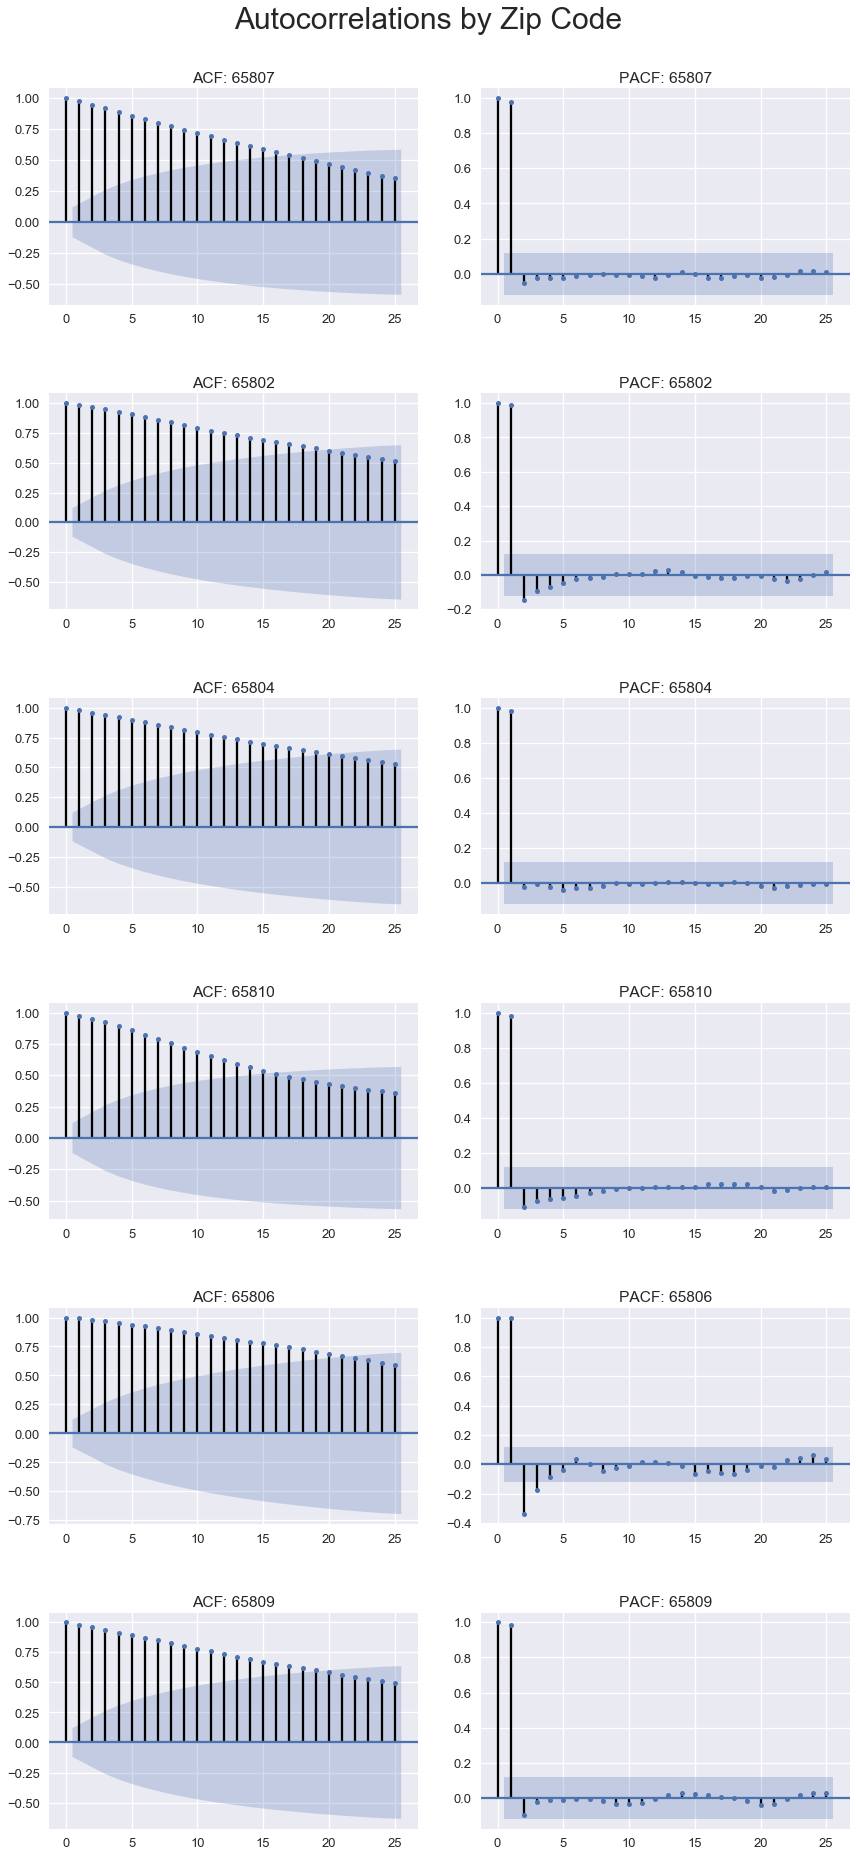

In [59]:
acf_pacf_charts(springfield)

### Model

                             ARIMA Model Results                              
Dep. Variable:               D2.65807   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1449.680
Method:                       css-mle   S.D. of innovations            186.900
Date:                Fri, 29 Jan 2021   AIC                           2905.361
Time:                        02:02:10   BIC                           2915.514
Sample:                    06-01-1996   HQIC                          2909.462
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.5819     20.990      0.123      0.902     -38.559      43.722
ar.L1.D2.65807     0.3988      0.062      6.442      0.000       0.277       0.520
                                    

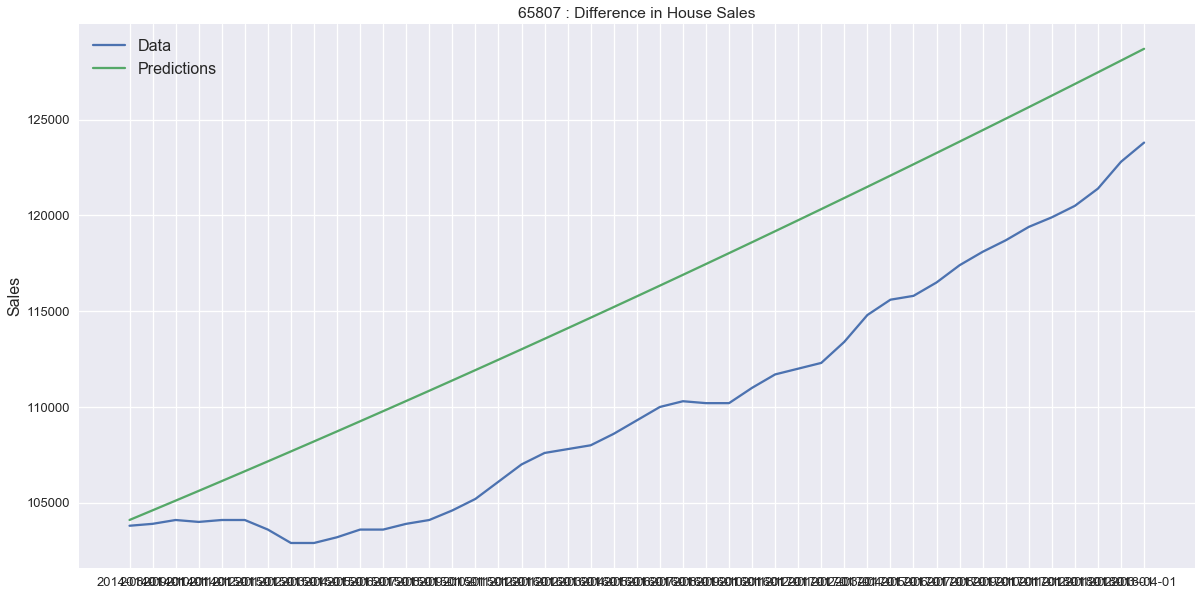

RMSE: 6041 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65802   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1445.499
Method:                       css-mle   S.D. of innovations            183.337
Date:                Fri, 29 Jan 2021   AIC                           2896.999
Time:                        02:02:11   BIC                           2907.152
Sample:                    06-01-1996   HQIC                          2901.100
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.9610     21.677      0.137      0.891     -39.525      45.447
ar.L1.D2.65802     0.4291      0.061      6.997      0.000       0.309       0.549
                   

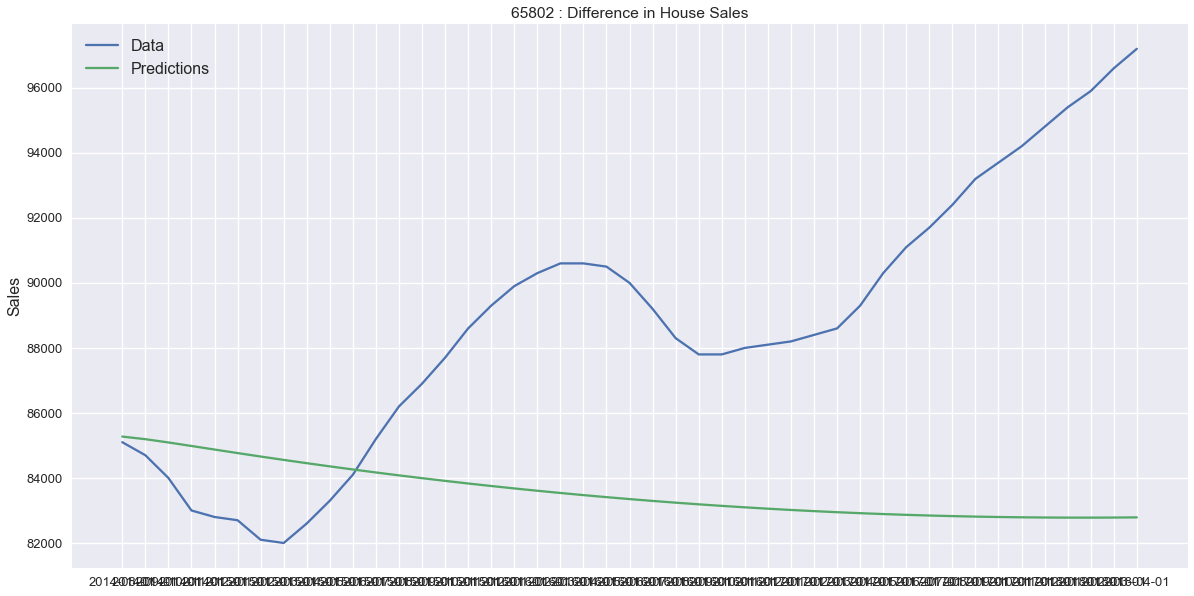

RMSE: 6989 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65804   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1435.018
Method:                       css-mle   S.D. of innovations            174.804
Date:                Fri, 29 Jan 2021   AIC                           2876.036
Time:                        02:02:11   BIC                           2886.190
Sample:                    06-01-1996   HQIC                          2880.137
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.8406     13.791     -0.061      0.951     -27.870      26.189
ar.L1.D2.65804     0.1422      0.067      2.124      0.034       0.011       0.273
                   

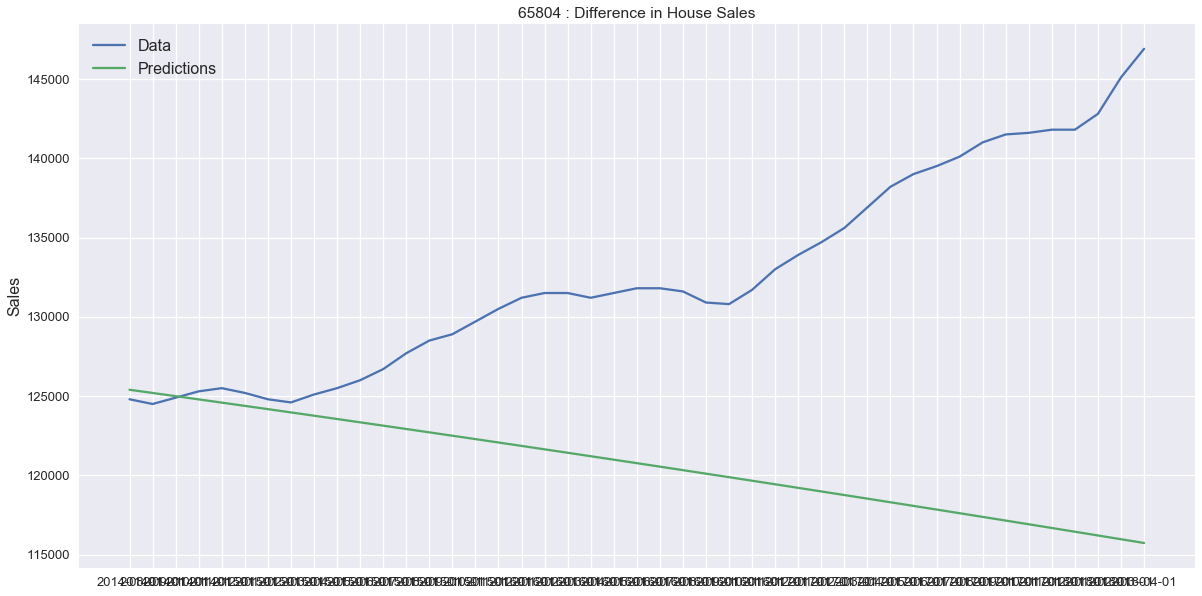

RMSE: 15011 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65810   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1552.112
Method:                       css-mle   S.D. of innovations            298.764
Date:                Fri, 29 Jan 2021   AIC                           3110.225
Time:                        02:02:11   BIC                           3120.378
Sample:                    06-01-1996   HQIC                          3114.326
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             15.0255     55.119      0.273      0.785     -93.006     123.057
ar.L1.D2.65810     0.6357      0.052     12.176      0.000       0.533       0.738
                  

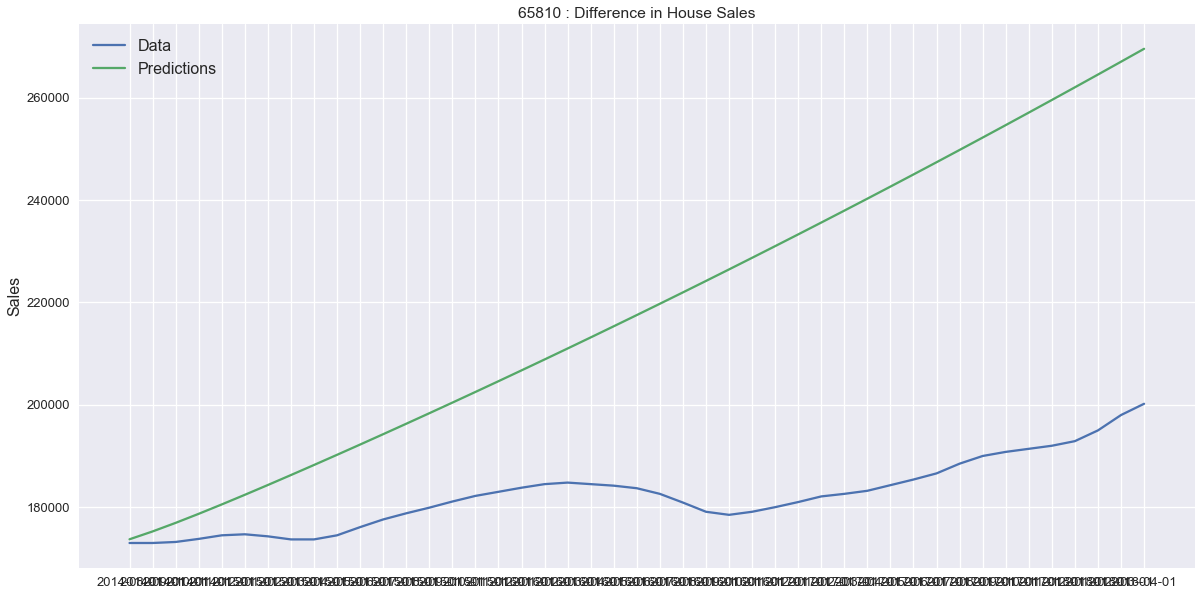

RMSE: 42907 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65806   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1467.043
Method:                       css-mle   S.D. of innovations            202.398
Date:                Fri, 29 Jan 2021   AIC                           2940.086
Time:                        02:02:12   BIC                           2950.239
Sample:                    06-01-1996   HQIC                          2944.187
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.4117     22.470      0.107      0.915     -41.628      46.451
ar.L1.D2.65806     0.3917      0.062      6.297      0.000       0.270       0.514
                  

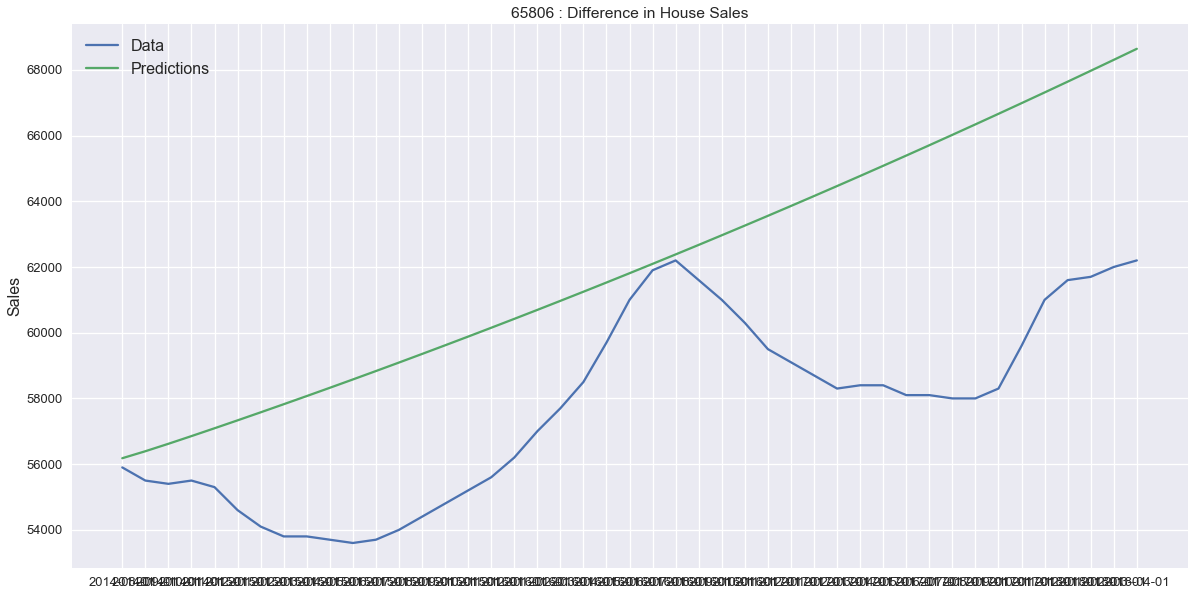

RMSE: 4890 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65809   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1729.345
Method:                       css-mle   S.D. of innovations            673.501
Date:                Fri, 29 Jan 2021   AIC                           3464.689
Time:                        02:02:12   BIC                           3474.843
Sample:                    06-01-1996   HQIC                          3468.790
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.2561    135.496      0.076      0.940    -255.310     275.823
ar.L1.D2.65809     0.6663      0.051     13.143      0.000       0.567       0.766
                   

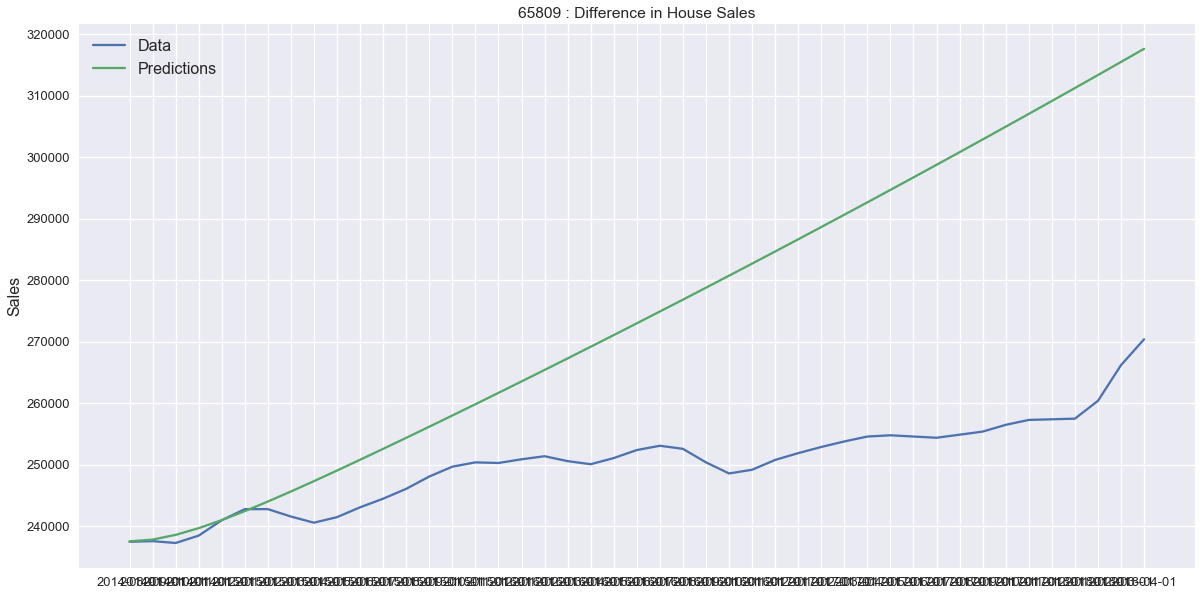

RMSE: 29993 
 
 



In [9]:
for col in sf_train:
    # model
    arima = ARIMA(sf_train[col], order= (1,2,0), freq='MS').fit()
    print(arima.summary())
    
    # forecast
    arima_forecast = arima.forecast(steps=len(sf_test))[0]
    
    # plotting forecast vs actual
    plt.figure(figsize=(20,10))

    plt.plot(sf_test[col])
    plt.plot(arima_forecast)

    plt.legend(('Data', 'Predictions'), fontsize=16)
    plt.title(col + ' : Difference in House Sales')
    plt.ylabel('Sales', fontsize=16);
    
    plt.show()

    #RMSE
    RMSE = np.sqrt(mean_squared_error(sf_test[col], arima_forecast))
    print('RMSE:', round(RMSE), '\n \n \n')

## Auto-ARIMA

In [10]:
from pmdarima.arima import auto_arima

> pip install pmdarima

In [11]:
order_dict = {}

In [12]:
for col in sf_train:
    auto = auto_arima(sf_train[col], max_order=None, max_p=10, max_q=10, max_d=5, information_criterion='aic')
    
    order_dict[col] = auto.get_params()['order']
    
    print(col)
    print(auto.summary(), '\n\n\n')

65807
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  220
Model:               SARIMAX(2, 2, 2)   Log Likelihood               -1446.488
Date:                Fri, 29 Jan 2021   AIC                           2902.977
Time:                        02:02:14   BIC                           2919.899
Sample:                             0   HQIC                          2909.812
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4201      0.065     21.828      0.000       1.293       1.548
ar.L2         -0.8737      0.054    -16.073      0.000      -0.980      -0.767
ma.L1         -1.2821      0.077    -16.666   

65809
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  220
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1942.773
Date:                Fri, 29 Jan 2021   AIC                           3891.546
Time:                        02:02:27   BIC                           3901.713
Sample:                             0   HQIC                          3895.652
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    266.7574    125.204      2.131      0.033      21.362     512.153
ma.L1          0.0345      0.006      6.088      0.000       0.023       0.046
sigma2      2.955e+06      0.063   4.66e+07   

In [13]:
order_dict

{'65807': (2, 2, 2),
 '65802': (3, 1, 1),
 '65804': (2, 2, 2),
 '65810': (1, 1, 1),
 '65806': (3, 1, 2),
 '65809': (0, 1, 1)}

## ARIMA (Final)

                             ARIMA Model Results                              
Dep. Variable:               D2.65807   No. Observations:                  218
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1433.957
Method:                       css-mle   S.D. of innovations            173.579
Date:                Fri, 29 Jan 2021   AIC                           2879.914
Time:                        02:02:27   BIC                           2900.221
Sample:                    06-01-1996   HQIC                          2888.116
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1923      5.692      0.034      0.973     -10.963      11.348
ar.L1.D2.65807     1.5038      0.083     18.189      0.000       1.342       1.666
ar.L2.D2.65807    -0.7217      0.083

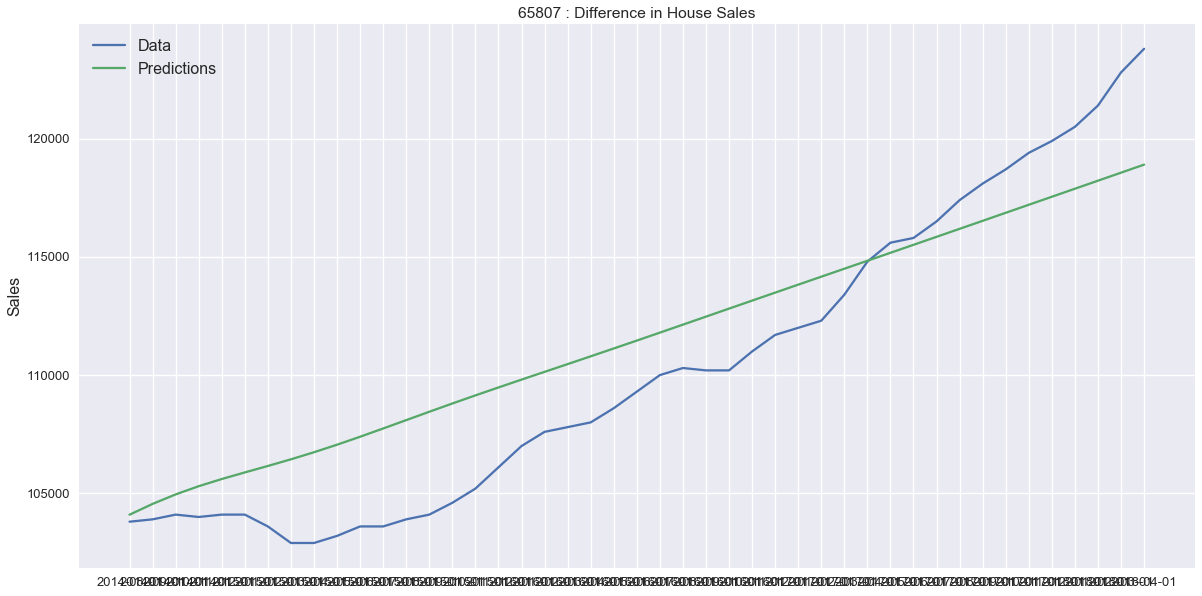

RMSE: 2674 




                             ARIMA Model Results                              
Dep. Variable:                D.65802   No. Observations:                  219
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1431.822
Method:                       css-mle   S.D. of innovations            166.269
Date:                Fri, 29 Jan 2021   AIC                           2875.643
Time:                        02:02:28   BIC                           2895.978
Sample:                    05-01-1996   HQIC                          2883.856
                         - 07-01-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            72.6306    103.902      0.699      0.485    -131.014     276.275
ar.L1.D.65802     1.8898      0.198      9.560      0.000       1.502       2.277
ar.L2.D.65802    -1.3660

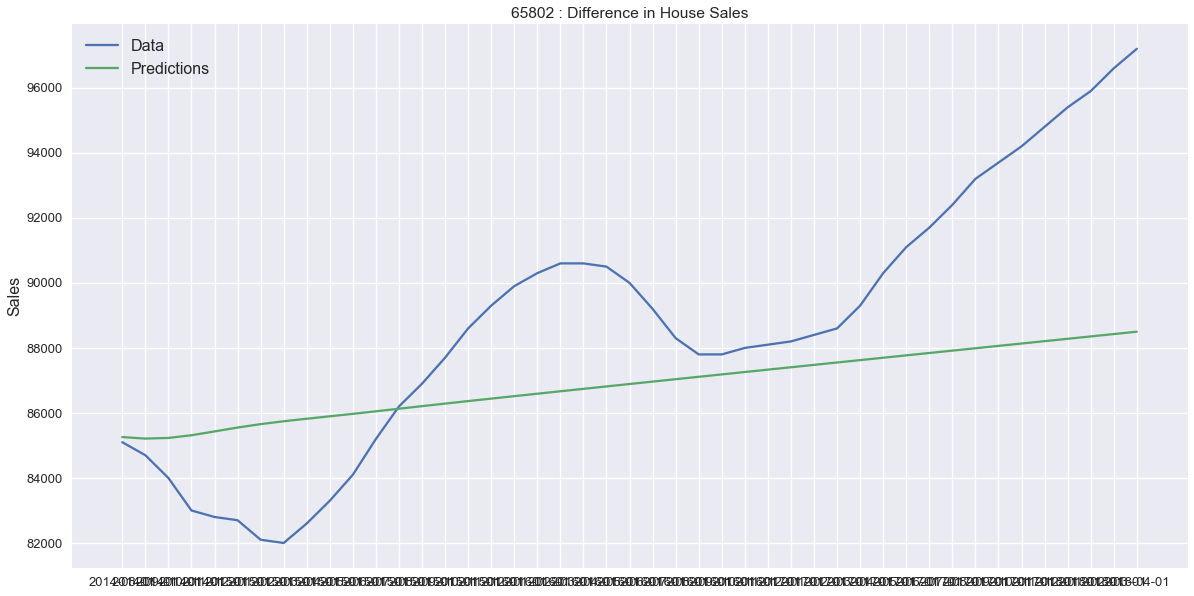

RMSE: 3714 




AR p-value too high, lowered order from (2, 2, 2)
                             ARIMA Model Results                              
Dep. Variable:               D2.65804   No. Observations:                  218
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1429.591
Method:                       css-mle   S.D. of innovations            169.466
Date:                Fri, 29 Jan 2021   AIC                           2869.183
Time:                        02:02:29   BIC                           2886.105
Sample:                    06-01-1996   HQIC                          2876.018
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.4151      1.689     -1.430      0.153      -5.725       0.894
ar.L1.D2.65804     0.8823      0.036     24.261      

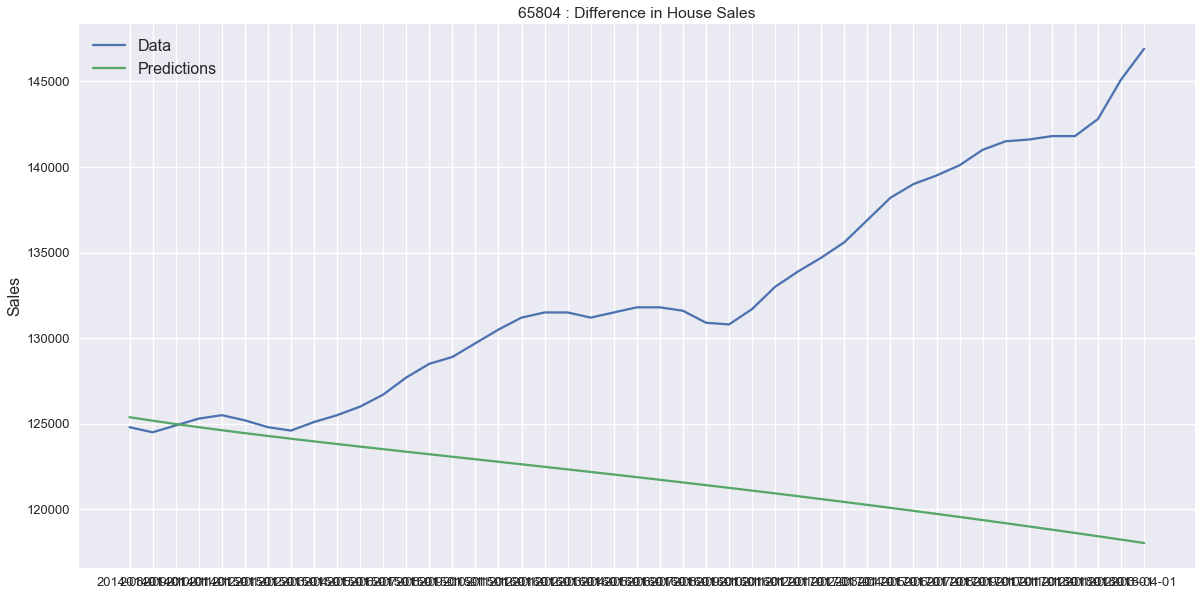

RMSE: 13689 




                             ARIMA Model Results                              
Dep. Variable:                D.65810   No. Observations:                  219
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1552.367
Method:                       css-mle   S.D. of innovations            287.641
Date:                Fri, 29 Jan 2021   AIC                           3112.735
Time:                        02:02:29   BIC                           3126.291
Sample:                    05-01-1996   HQIC                          3118.210
                         - 07-01-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           217.9994    343.844      0.634      0.526    -455.922     891.921
ar.L1.D.65810     0.9079      0.028     32.243      0.000       0.853       0.963
ma.L1.D.65810     0.703

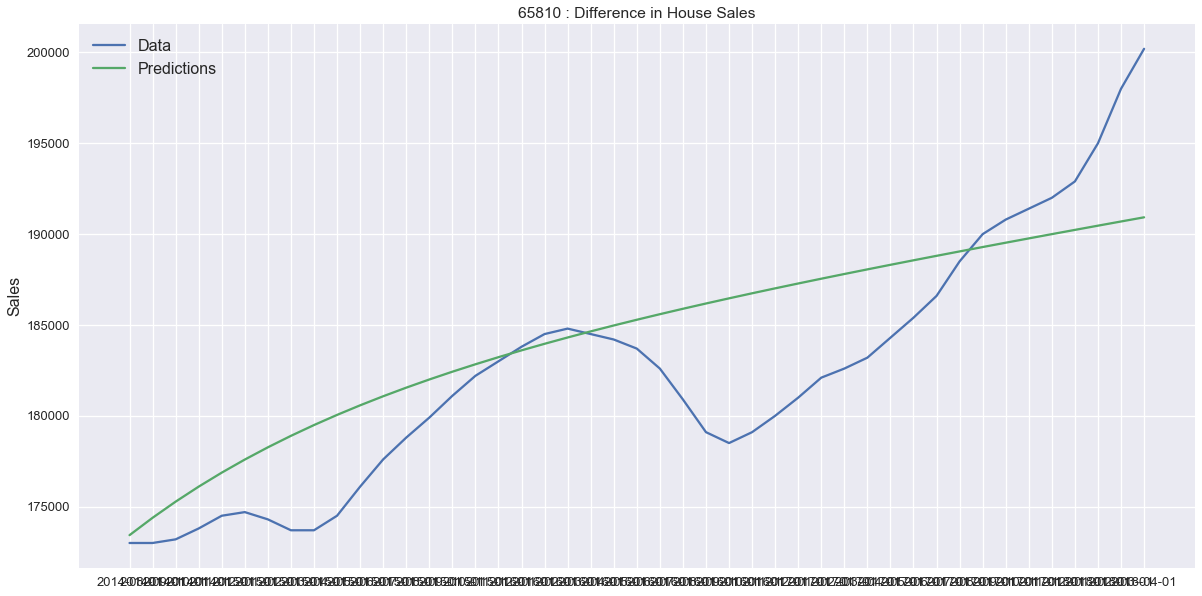

RMSE: 4123 




AR p-value too high, lowered order from (3, 1, 2)
AR p-value too high, lowered order from [2 1 2]
                             ARIMA Model Results                              
Dep. Variable:                D.65806   No. Observations:                  219
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1457.182
Method:                       css-mle   S.D. of innovations            186.723
Date:                Fri, 29 Jan 2021   AIC                           2924.364
Time:                        02:02:30   BIC                           2941.310
Sample:                    05-01-1996   HQIC                          2931.208
                         - 07-01-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            78.1658     89.075      0.878      0.380     -96.417     252.749
ar.L1.D.

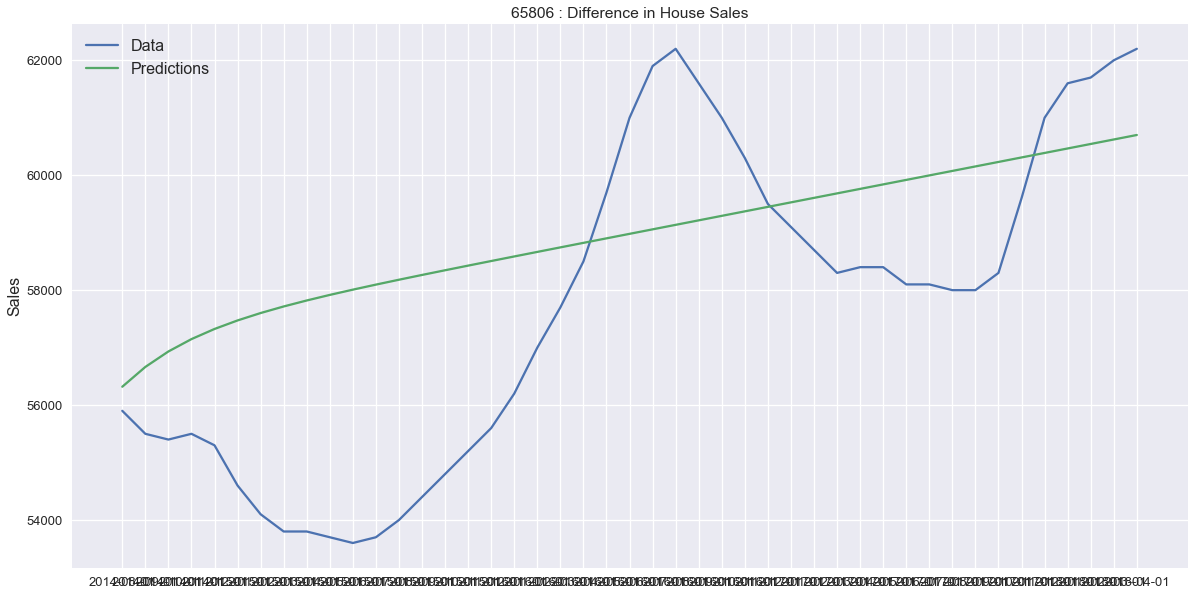

RMSE: 2397 




                             ARIMA Model Results                              
Dep. Variable:                D.65809   No. Observations:                  219
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1816.712
Method:                       css-mle   S.D. of innovations            964.205
Date:                Fri, 29 Jan 2021   AIC                           3639.424
Time:                        02:02:31   BIC                           3649.591
Sample:                    05-01-1996   HQIC                          3643.530
                         - 07-01-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           361.6633    126.668      2.855      0.004     113.399     609.928
ma.L1.D.65809     0.9484      0.021     46.100      0.000       0.908       0.989
                        

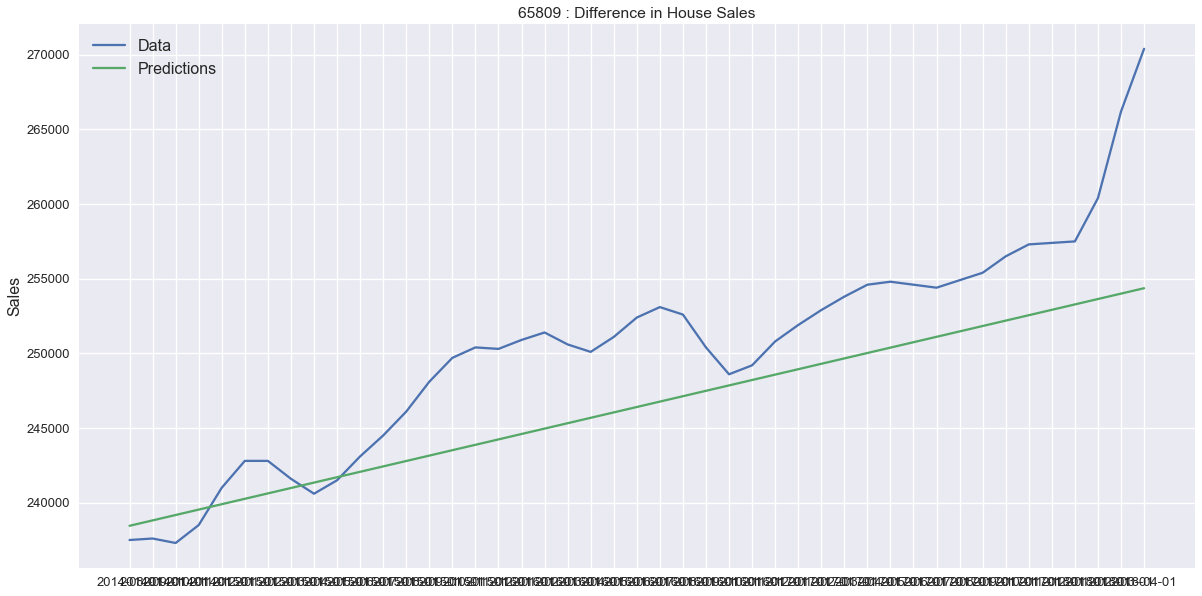

RMSE: 4974 






In [14]:
ar_substring = 'ar'
ma_substring = 'ma'


for col in sf_train:
    
    arima_flag = False
    # model
    arima = ARIMA(sf_train[col], order=order_dict[col] , freq='MS').fit()
    
    
    # looping until high p-values are eliminated
    while arima_flag == False:
        
        # determining if new order is needed
        for i in range(len(arima.pvalues)):
            
            # new order is needed
            if (i>0) and (arima.pvalues[i] > .05):
                if ar_substring in arima.pvalues.index[i]:
                    # ar has high p-value
                    print('AR p-value too high, lowered order from', order_dict[col])
                    order_dict[col] = np.subtract(order_dict[col], (1,0,0))
                    arima = ARIMA(sf_train[col], order=order_dict[col] , freq='MS').fit()
                    break

                elif ma_substring in arima.pvalues.index[i]:
                    #ma has high p value
                    print('MA p-value too high, lowered order from', order_dict[col])
                    order_dict[col] = np.subtract(order_dict[col], (0,0,1))
                    arima = ARIMA(sf_train[col], order=order_dict[col] , freq='MS').fit()
                    break
            
            # current order has no p_values (exit while loop)
            elif i == len(arima.pvalues)-1:
                arima_flag = True
            
    
    print(arima.summary())
    
    # forecast
    arima_forecast = arima.forecast(steps=len(sf_test))[0]
    
    # plotting forecast vs actual
    plt.figure(figsize=(20,10))

    plt.plot(sf_test[col])
    plt.plot(arima_forecast)

    plt.legend(('Data', 'Predictions'), fontsize=16)
    plt.title(col + ' : Difference in House Sales')
    plt.ylabel('Sales', fontsize=16);
    
    plt.show()

    #RMSE
    RMSE = np.sqrt(mean_squared_error(sf_test[col], arima_forecast))
    print('RMSE:', round(RMSE), '\n\n\n\n')

## Facebook Prophet